# **Forecasting Base Station using ARIMA**

In [23]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time

In [24]:
# Prepare test targets (last value per sector)
def get_test_targets(df, seq_len):
    y, ids = [], []
    for item_id, group in df.groupby('item_id'):
        vals = group.sort_values('timestamp')['target'].values
        if len(vals) >= seq_len + 1:
            y.append(vals[-1])
            ids.append(item_id)
    return np.array(y), ids

In [25]:
# Load data
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/chronos_finetune_dataset.csv')

## **Training and Evaluation** 

In [29]:
SEQ_LEN = 20

y_test, test_ids = get_test_targets(test_df, SEQ_LEN)

# ARIMA prediction for each sector
preds = []
skipped = []

start = time.time()
for item_id in test_ids:
    train_series = train_df[train_df['item_id'] == item_id].sort_values('timestamp')['target'].values
    if len(train_series) < SEQ_LEN:
        skipped.append(item_id)
        preds.append(np.nan)
        continue
    try:
        # ARIMA order (p,d,q) can be tuned; (1,0,0) is AR(1)
        model = ARIMA(train_series, order=(5,0,0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=8)
        preds.append(forecast[0])
    except Exception as e:
        print(f"Sector {item_id} ARIMA error: {e}")
        preds.append(np.nan)

elapsed_time = time.time() - start
print(f"ARIMA prediction time: {elapsed_time:.2f} seconds")

# Remove skipped/failed sectors from comparison
y_test_valid = []
preds_valid = []
ids_valid = []
for actual, pred, item_id in zip(y_test, preds, test_ids):
    if not np.isnan(pred):
        y_test_valid.append(actual)
        preds_valid.append(pred)
        ids_valid.append(item_id)

rmse = np.sqrt(mean_squared_error(y_test_valid, preds_valid))
print(f"ARIMA RMSE: {rmse:.4f}")

for item_id, actual, pred in zip(ids_valid, y_test_valid, preds_valid):
    print(f"Sector {item_id}: Actual={actual:.4f}, Predicted={pred:.4f}")

if skipped:
    print(f"Skipped {len(skipped)} sectors due to insufficient training data.")

/home/infres/vonguyen/rai-6green-miniproj/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA prediction time: 41.20 seconds
ARIMA RMSE: 7.1781
Sector T36870A: Actual=15.4447, Predicted=22.2392
Sector T36870B: Actual=5.5754, Predicted=5.8057
Sector T70721A: Actual=3.7519, Predicted=2.4478
Sector T70721B: Actual=3.6235, Predicted=4.1662
Sector T70721C: Actual=1.5962, Predicted=1.0758
Sector T70722A: Actual=11.2690, Predicted=11.4668
Sector T70722B: Actual=46.4775, Predicted=41.2346
Sector T70722C: Actual=59.1629, Predicted=54.1805
Sector T70724A: Actual=38.9410, Predicted=36.4304
Sector T70724B: Actual=25.5653, Predicted=34.5953
Sector T70724C: Actual=30.8441, Predicted=31.8695
Sector T70725A: Actual=39.3438, Predicted=48.0163
Sector T70725B: Actual=48.3055, Predicted=49.0002
Sector T70725C: Actual=35.1085, Predicted=27.2279
Sector T70730A: Actual=44.0492, Predicted=58.4498
Sector T70730B: Actual=42.1487, Predicted=48.6488
Sector T70730C: Actual=20.3877, Predicted=15.6976
Sector T70731A: Actual=9.6862, Predicted=9.2041
Sector T70731B: Actual=42.1508, Predicted=39.3773
Sect

## Forecast Visualization

Randomly selected sector: T70743A


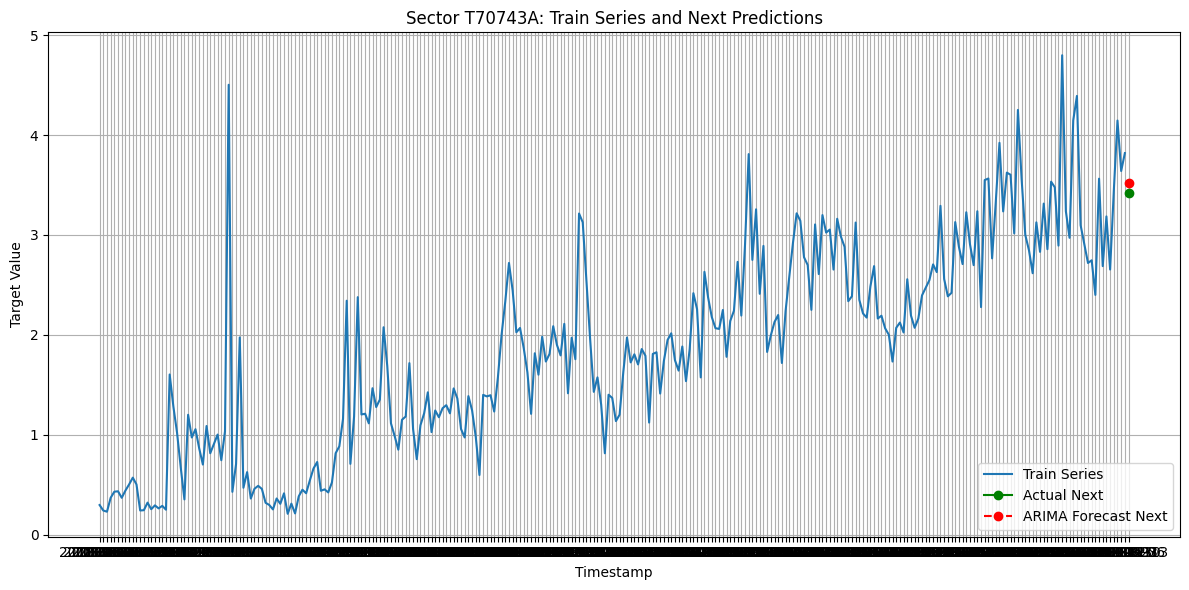

In [30]:
import random

# Select a random sector from chronos_train.csv
sector_ids = train_df['item_id'].unique()
random_sector = random.choice(sector_ids)
print(f"Randomly selected sector: {random_sector}")

# Get training and test data for this sector
train_sector = train_df[train_df['item_id'] == random_sector].sort_values('timestamp')
test_sector = test_df[test_df['item_id'] == random_sector].sort_values('timestamp')

# Fit ARIMA on the training series
train_series = train_sector['target'].values
model = ARIMA(train_series, order=(1,0,0))
model_fit = model.fit()

# Forecast last measurement
n_forecast = 1
forecast = []
current_series = train_series.copy()
for i in range(n_forecast):
    temp_model = ARIMA(current_series, order=(1,0,0))
    temp_fit = temp_model.fit()
    next_pred = temp_fit.forecast(steps=1)[0]
    forecast.append(next_pred)
    current_series = np.append(current_series, next_pred)
forecast = np.array(forecast)

# Find the last timestamp in training and get the next 8 timestamps from test
last_train_time = train_sector['timestamp'].max()
future_test = test_sector[test_sector['timestamp'] > last_train_time].sort_values('timestamp')
actual_next = future_test['target'].values[:n_forecast]
timestamps_pred = future_test['timestamp'].values[:n_forecast]
if len(actual_next) < n_forecast:
    forecast = forecast[:len(actual_next)]
    print(f"Warning: Only {len(actual_next)} future points available for sector {random_sector}.")

timestamps_train = train_sector['timestamp'].values

# Plot
plt.figure(figsize=(12,6))
plt.plot(timestamps_train, train_series, label='Train Series')
plt.plot(timestamps_pred, actual_next, 'go-', label='Actual Next')
plt.plot(timestamps_pred, forecast, 'ro--', label='ARIMA Forecast Next')
plt.xlabel('Timestamp')
plt.ylabel('Target Value')
plt.title(f'Sector {random_sector}: Train Series and Next Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Randomly selected sector: T78279C


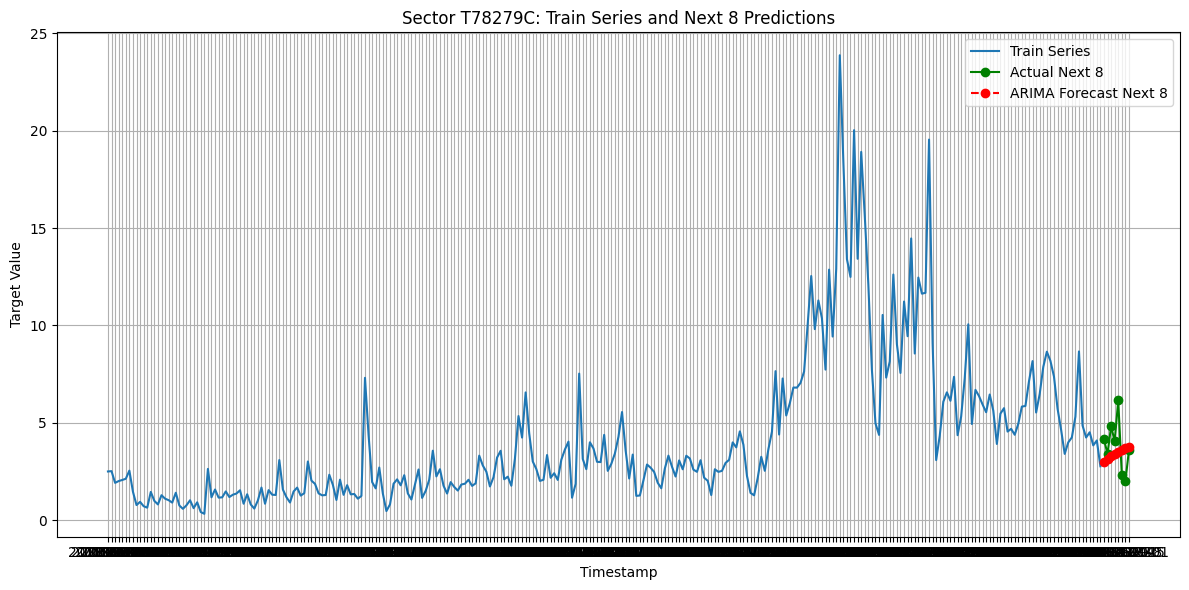

In [33]:
import random

# Select a random sector from the full dataset
sector_ids = test_df['item_id'].unique()
random_sector = random.choice(sector_ids)
print(f"Randomly selected sector: {random_sector}")

sector_data = test_df[test_df['item_id'] == random_sector].sort_values('timestamp')
series = sector_data['target'].values
timestamps = sector_data['timestamp'].values

n_forecast = 8
train_series = series[:-n_forecast]
train_timestamps = timestamps[:-n_forecast]
future_actual = series[-n_forecast:]
future_timestamps = timestamps[-n_forecast:]

# Fit ARIMA on the training series
model = ARIMA(train_series, order=(1,0,0))
model_fit = model.fit()

# Forecast next 8 points recursively
forecast = []
current_series = train_series.copy()
for i in range(n_forecast):
    temp_model = ARIMA(current_series, order=(1,0,0))
    temp_fit = temp_model.fit()
    next_pred = temp_fit.forecast(steps=1)[0]
    forecast.append(next_pred)
    current_series = np.append(current_series, next_pred)
forecast = np.array(forecast)

# Plot
plt.figure(figsize=(12,6))
plt.plot(train_timestamps, train_series, label='Train Series')
plt.plot(future_timestamps, future_actual, 'go-', label='Actual Next 8')
plt.plot(future_timestamps, forecast, 'ro--', label='ARIMA Forecast Next 8')
plt.xlabel('Timestamp')
plt.ylabel('Target Value')
plt.title(f'Sector {random_sector}: Train Series and Next 8 Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()